# 1. Setup

In [2]:
import tensorflow as tf
import os

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 2. Data Cleaning

In [3]:
import cv2
import imghdr

In [5]:
# Directory containing the image data
data_dir = r'C:\Users\Marvin\Documents\WBS\Final_Project\Data\data' 

In [6]:
class_names = os.listdir(data_dir)
class_names

['Apple___alternaria_leaf_spot',
 'Apple___black_rot',
 'Apple___brown_spot',
 'Apple___gray_spot',
 'Apple___healthy',
 'Apple___rust',
 'Apple___scab',
 'Bell_pepper___bacterial_spot',
 'Bell_pepper___healthy',
 'Blueberry___healthy',
 'Cassava___bacterial_blight',
 'Cassava___brown_streak_disease',
 'Cassava___green_mottle',
 'Cassava___healthy',
 'Cassava___mosaic_disease',
 'Cherry___healthy',
 'Cherry___powdery_mildew',
 'Corn___common_rust',
 'Corn___gray_leaf_spot',
 'Corn___healthy',
 'Corn___northern_leaf_blight',
 'Grape___black_measles',
 'Grape___black_rot',
 'Grape___healthy',
 'Grape___leaf_blight',
 'Orange___citrus_greening',
 'Peach___bacterial_spot',
 'Peach___healthy',
 'Potato___bacterial_wilt',
 'Potato___early_blight',
 'Potato___healthy',
 'Potato___late_blight',
 'Potato___nematode',
 'Potato___pests',
 'Potato___phytophthora',
 'Potato___virus',
 'Raspberry___healthy',
 'Rice___bacterial_blight',
 'Rice___blast',
 'Rice___brown_spot',
 'Rice___tungro',
 'roomp

In [7]:
num_classes = len(os.listdir(data_dir))
num_classes

62

In [8]:
# List of image extensions
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [10]:
# Remove images with invalid extensions
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                # os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

: 

# 3. Load Data

In [4]:
import numpy as np
from matplotlib import pyplot as plt

In [10]:
batch_size = 16
image_size = (256, 256)

In [11]:
data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    seed=42,
    image_size=image_size,
    batch_size=batch_size
)

Found 86046 files belonging to 62 classes.


In [12]:
data_iterator = data.as_numpy_iterator()

In [13]:
batch = data_iterator.next()

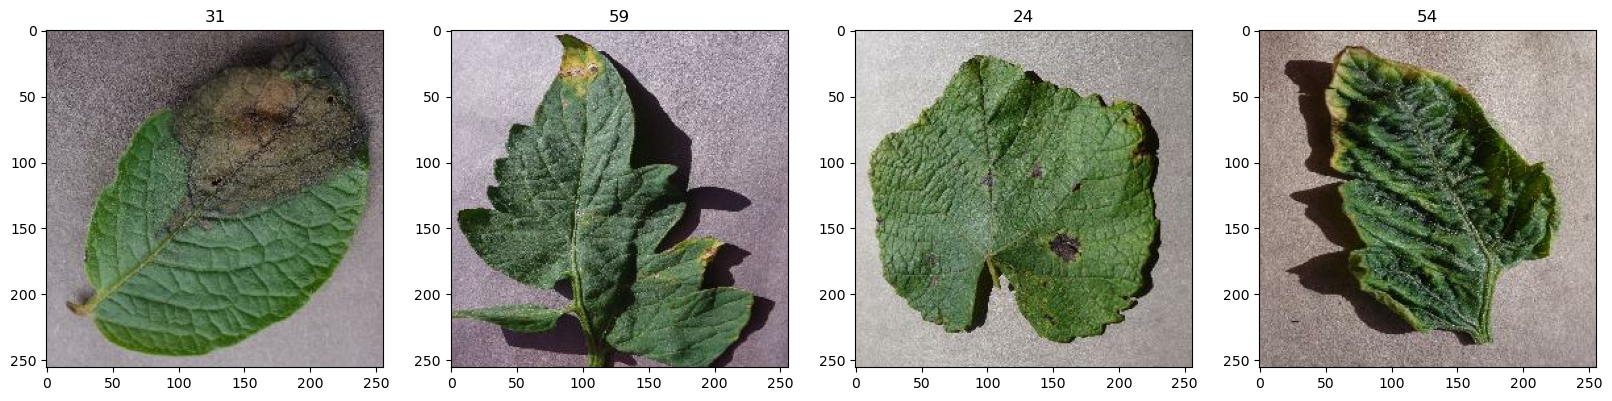

In [14]:
# Display sample images
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Preprocess

### 4.1. Scaling

In [15]:
data_scaled = data.map(lambda x,y: (x/255, tf.one_hot(y, num_classes)))

In [16]:
data_scaled.as_numpy_iterator().next()

(array([[[[0.68235296, 0.6745098 , 0.69411767],
          [0.6745098 , 0.6666667 , 0.6862745 ],
          [0.67058825, 0.6627451 , 0.68235296],
          ...,
          [0.43137255, 0.39215687, 0.38431373],
          [0.49411765, 0.45490196, 0.44705883],
          [0.5058824 , 0.46666667, 0.45882353]],
 
         [[0.6666667 , 0.65882355, 0.6784314 ],
          [0.65882355, 0.6509804 , 0.67058825],
          [0.654902  , 0.64705884, 0.6666667 ],
          ...,
          [0.54901963, 0.50980395, 0.5019608 ],
          [0.50980395, 0.47058824, 0.4627451 ],
          [0.5254902 , 0.4862745 , 0.47843137]],
 
         [[0.6666667 , 0.65882355, 0.6784314 ],
          [0.654902  , 0.64705884, 0.6666667 ],
          [0.6431373 , 0.63529414, 0.654902  ],
          ...,
          [0.5137255 , 0.4745098 , 0.46666667],
          [0.5647059 , 0.5254902 , 0.5176471 ],
          [0.46666667, 0.42745098, 0.41960785]],
 
         ...,
 
         [[0.6313726 , 0.6156863 , 0.61960787],
          [0.63921

In [17]:
# validate scaling 0-1

scaled_iterator = data_scaled.as_numpy_iterator()
batch_scaled = scaled_iterator.next()
batch_scaled[0].max()

1.0

### 4.2. Splitting

In [18]:
train_size = int(0.7 * len(data))
val_size = int(0.2 * len(data))
test_size = len(data) - train_size - val_size

In [19]:
test_size

539

In [20]:
train_data = data_scaled.take(train_size)
val_data = data_scaled.skip(train_size).take(val_size)
test_data = data_scaled.skip(train_size + val_size).take(test_size)

# 5. Deep Learning Model

### 5.1. Building

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications import ResNet50 
from tensorflow.keras import layers, models

### 5.1.1. ResNet50 + Sequantial

In [22]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers[-2:]:
    layer.trainable = True

# Create a new model on top
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(num_classes, activation='softmax'))

In [23]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                        

In [25]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  
    patience=5,          
    restore_best_weights=True  
)

In [26]:
epochs = 50
history = model.fit(
    train_data,
    epochs=epochs,
    validation_data=val_data,
    callbacks=[early_stopping]
)

Epoch 1/50
3764/3764 [==============================] - 765s 201ms/step - loss: 2.3336 - accuracy: 0.3519 - val_loss: 3.7915 - val_accuracy: 0.2231
Epoch 2/50
3764/3764 [==============================] - 744s 198ms/step - loss: 1.1719 - accuracy: 0.6267 - val_loss: 1.2391 - val_accuracy: 0.6173
Epoch 3/50
3764/3764 [==============================] - 736s 196ms/step - loss: 0.8005 - accuracy: 0.7362 - val_loss: 1.1059 - val_accuracy: 0.6831
Epoch 4/50
3764/3764 [==============================] - 729s 194ms/step - loss: 0.6378 - accuracy: 0.7867 - val_loss: 1.1089 - val_accuracy: 0.7377
Epoch 5/50
3764/3764 [==============================] - 749s 199ms/step - loss: 0.5600 - accuracy: 0.8132 - val_loss: 0.7173 - val_accuracy: 0.7673
Epoch 6/50
3764/3764 [==============================] - 726s 193ms/step - loss: 0.4883 - accuracy: 0.8357 - val_loss: 0.5452 - val_accuracy: 0.8281
Epoch 7/50
3764/3764 [==============================] - 725s 193ms/step - loss: 0.4444 - accuracy: 0.8503 - val_

### 5.1.2. Sequential

In [119]:
model = models.Sequential()

# Layers
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dropout(0.7)) 

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(num_classes, activation='softmax'))

ValueError: Exception encountered when calling layer "max_pooling2d_65" (type MaxPooling2D).

Negative dimension size caused by subtracting 2 from 1 for '{{node max_pooling2d_65/MaxPool}} = MaxPool[T=DT_FLOAT, data_format="NHWC", explicit_paddings=[], ksize=[1, 2, 2, 1], padding="VALID", strides=[1, 2, 2, 1]](Placeholder)' with input shapes: [?,1,1,32].

Call arguments received by layer "max_pooling2d_65" (type MaxPooling2D):
  • inputs=tf.Tensor(shape=(None, 1, 1, 32), dtype=float32)

In [65]:
# Compile the model with categorical crossentropy loss function
optimizer = RMSprop(learning_rate=0.001)  
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [66]:
# Early Stopping Callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [67]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_51 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 batch_normalization_68 (Bat  (None, 254, 254, 16)     64        
 chNormalization)                                                
                                                                 
 max_pooling2d_51 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_52 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 batch_normalization_69 (Bat  (None, 125, 125, 32)     128       
 chNormalization)                                                
                                                     

### 5.2. Training

In [68]:
# Directory for storing TensorBoard logs
logdir=r'C:\Users\Marvin\Documents\WBS\Final_Project\logs'

In [69]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [70]:
# Train the model
hist = model.fit(train_data, epochs=50, validation_data=val_data, callbacks=[tensorboard_callback])

Epoch 1/50
1882/1882 [==============================] - 143s 75ms/step - loss: 1.1482 - accuracy: 0.6533 - val_loss: 0.8778 - val_accuracy: 0.7125
Epoch 2/50
1882/1882 [==============================] - 140s 74ms/step - loss: 0.6851 - accuracy: 0.7758 - val_loss: 0.7655 - val_accuracy: 0.7434
Epoch 3/50
1882/1882 [==============================] - 137s 73ms/step - loss: 0.5523 - accuracy: 0.8146 - val_loss: 0.5393 - val_accuracy: 0.8123
Epoch 4/50
1882/1882 [==============================] - 141s 75ms/step - loss: 0.4697 - accuracy: 0.8408 - val_loss: 0.7334 - val_accuracy: 0.7606
Epoch 5/50
1882/1882 [==============================] - 137s 73ms/step - loss: 0.4148 - accuracy: 0.8581 - val_loss: 0.5546 - val_accuracy: 0.8157
Epoch 6/50
1882/1882 [==============================] - 139s 74ms/step - loss: 0.3783 - accuracy: 0.8692 - val_loss: 0.7202 - val_accuracy: 0.7718
Epoch 7/50
1882/1882 [==============================] - 137s 73ms/step - loss: 0.3379 - accuracy: 0.8833 - val_loss: 0

### 5.3. Performance

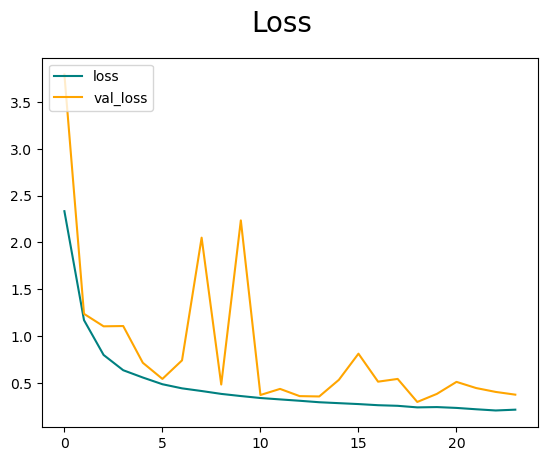

In [62]:
# Plot training and validation loss
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

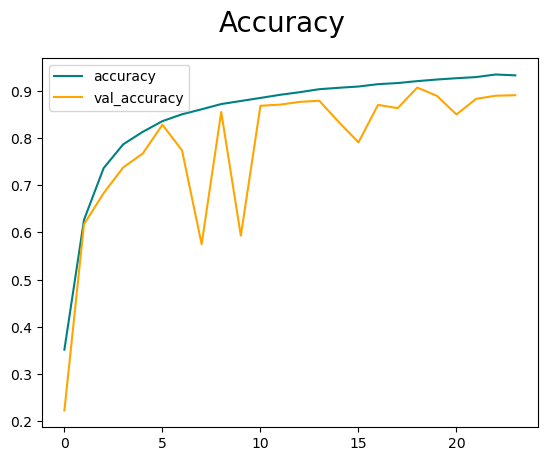

In [63]:
# Plot training and validation accuracy
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

### 5.4. Evaluation

In [30]:
from tensorflow.keras.metrics import CategoricalAccuracy, Precision, Recall

In [31]:
# Performance-Metriken berechnen
test_loss, test_accuracy = model.evaluate(test_data)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

539/539 [==============================] - 67s 48ms/step - loss: 0.3009 - accuracy: 0.9056
Test Loss: 0.3009417653083801, Test Accuracy: 0.9055903553962708


In [32]:
# Metrics for multi-class classification
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [54]:
# Update metrics over the test dataset
for batch in test_data.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 24ms/step


In [34]:
# Calculate F1-score
precision = pre.result().numpy()
recall = re.result().numpy()
f1_score = 2 * (precision * recall) / (precision + recall)

In [61]:
# Output performance metrics
print(f'Accuracy: {acc.result().numpy()}, Precision: {precision}, Recall: {recall}, F1-Score: {f1_score}')

Accuracy: 0.9064022302627563, Precision: 0.9356259703636169, Recall: 0.8866852521896362, F1-Score: 0.9104984648700756


### 5.5. Random Test

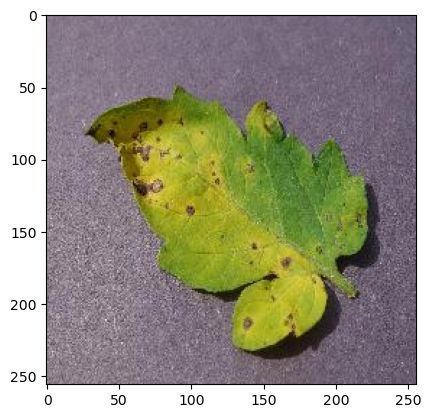

In [5]:
# Load a test image
img = cv2.imread(r'C:\Users\Marvin\Documents\WBS\Final_Project\Data\test_data\Tomato___septoria_leaf_spot\ff3ff139-ca11-4e48-b78e-29147bec8ae4___Keller.St_CG 1981.JPG')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

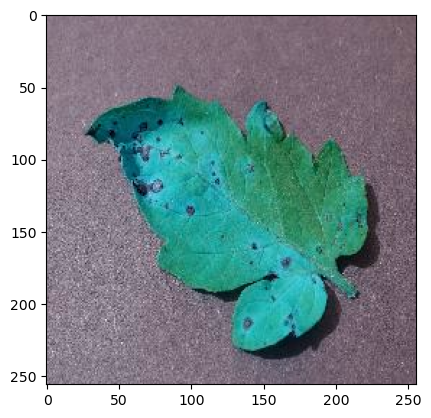

In [57]:
# Resize the image
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [58]:
# Predict the class of the resized image
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 30ms/step


In [59]:
yhat

array([[2.70714800e-16, 1.02236608e-09, 2.80551624e-13, 5.81170147e-11,
        7.45354996e-08, 3.35117777e-14, 1.85870395e-08, 1.01523040e-06,
        4.58096538e-09, 8.08979550e-08, 8.36362035e-10, 1.80105565e-06,
        1.25306424e-05, 2.03718423e-06, 8.63851092e-05, 4.01177225e-12,
        2.77272285e-11, 7.03473145e-16, 1.53916644e-15, 3.92865819e-16,
        3.42277476e-13, 8.45561843e-08, 1.04297349e-10, 9.17478482e-10,
        1.35473588e-12, 1.50128445e-12, 1.40719871e-08, 8.21464452e-10,
        1.02551692e-08, 8.11387846e-10, 1.31911357e-10, 3.81735615e-12,
        7.38564175e-18, 3.81191256e-09, 4.24886309e-13, 2.15875828e-09,
        2.85989330e-07, 4.44051081e-11, 1.99022012e-14, 2.97258572e-12,
        4.45425034e-16, 7.22321261e-07, 2.50606463e-11, 1.44100695e-11,
        8.24851476e-09, 7.31064226e-15, 3.60922331e-14, 7.89260726e-15,
        4.89114771e-13, 1.06716366e-13, 2.25543909e-06, 2.27302706e-04,
        3.32154991e-06, 1.93960227e-06, 4.92141582e-04, 2.780199

In [60]:
predicted_class = np.argmax(yhat) # Index of the class with the maximum prediction value
predicted_class_name = class_names[predicted_class-1]
print(f'Predicted class: {predicted_class_name}')

Predicted class: Tomato___leaf_curl


In [1]:
predicted_class

NameError: name 'predicted_class' is not defined

### 5.6. Hyperparameter Optimization

In [32]:
from bayes_opt import BayesianOptimization
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Funktion zur Erstellung und Bewertung des Modells
def create_and_evaluate_model(optimizer, dropout_rate, learning_rate):
    model = Sequential()
    model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(Conv2D(32, (3,3), 1, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(Conv2D(16, (3,3), 1, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(num_classes, activation='softmax'))
    
    optimizer_obj = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer_obj, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model
    hist = model.fit(train_data, epochs=30, validation_data=val_data, verbose=0)
    
    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(test_data, verbose=0)
    
    return test_accuracy

# Definition des Hyperparameterbereichs
pbounds = {'optimizer': (0, 1),  # 0: 'adam', 1: 'rmsprop'
           'dropout_rate': (0.3, 0.7),
           'learning_rate': (0.001, 0.1)}

# Definition der Bayesian Optimization
optimizer = BayesianOptimization(f=create_and_evaluate_model, pbounds=pbounds, random_state=42)

# Durchführen der Optimierung
optimizer.maximize(init_points=5, n_iter=10)

# Ausgabe der besten Hyperparameter
print(optimizer.max)





|   iter    |  target   | dropou... | learni... | optimizer |
-------------------------------------------------------------
| 1         | 0.7291    | 0.4498    | 0.09512   | 0.732     |
| 2         | 0.8024    | 0.5395    | 0.01645   | 0.156     |
| 3         | 0.7653    | 0.3232    | 0.08675   | 0.6011    |
| 4         | 0.8576    | 0.5832    | 0.003038  | 0.9699    |
| 5         | 0.8001    | 0.633     | 0.02202   | 0.1818    |
| 6         | 0.8733    | 0.7       | 0.001     | 1.0       |
| 7         | 0.6511    | 0.7       | 0.1       | 1.0       |
| 8         | 0.7024    | 0.4301    | 0.04843   | 0.1428    |
| 9         | 0.1328    | 0.6772    | 0.03742   | 0.2213    |
| 10        | 0.5598    | 0.6576    | 0.08629   | 0.4132    |
| 11        | 0.6752    | 0.4329    | 0.06831   | 0.963     |
| 12        | 0.7002    | 0.3378    | 0.08033   | 0.5957    |
| 13        | 0.6981    | 0.4612    | 0.08423   | 0.7576    |
| 14        | 0.8009    | 0.5441    | 0.02292   | 0.9761    |
| 15    

# 6. Save the Model

In [4]:
from tensorflow.keras.models import load_model
import os

In [42]:
model.save(os.path.join(r'C:\Users\Marvin\Documents\WBS\Final_Project\Dr.-Greenthumb-Decoding-Nature-s-Needs\Models','multi_diseases_classifier_ResNet_90.h5'))

In [5]:
new_model = load_model(os.path.join(r'C:\Users\Marvin\Documents\WBS\Final_Project\Dr.-Greenthumb-Decoding-Nature-s-Needs\Models','multi_diseases_classifier_ResNet_90.h5'))

In [72]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 54ms/step


array([[6.55485983e-23, 0.00000000e+00, 1.71000209e-31, 2.19938459e-22,
        1.32631240e-14, 2.79394705e-28, 1.49189732e-12, 0.00000000e+00,
        9.20858520e-27, 9.86563884e-24, 0.00000000e+00, 8.27585618e-37,
        2.34672715e-26, 2.92179482e-20, 7.61363851e-38, 6.91408788e-34,
        9.89409011e-32, 5.37330346e-21, 1.40778414e-17, 9.99999881e-01,
        8.61664767e-11, 9.33226886e-38, 1.68177243e-29, 1.45823805e-35,
        1.22798125e-38, 6.27569990e-30, 9.07254660e-16, 0.00000000e+00,
        0.00000000e+00, 4.73472139e-32, 8.50887819e-21, 2.93752435e-24,
        0.00000000e+00, 1.47235599e-22, 1.29332085e-38, 1.80646669e-31,
        0.00000000e+00, 1.56177878e-19, 3.48549314e-11, 4.29377679e-11,
        5.29365912e-26, 2.58948600e-27, 1.16357425e-23, 0.00000000e+00,
        0.00000000e+00, 1.09095014e-12, 8.30854390e-08, 5.97266660e-22,
        1.13235712e-12, 8.60003636e-25, 5.35797201e-29, 2.11250482e-24,
        4.91777417e-25, 3.61372665e-09, 1.04388813e-32, 4.565128

### 7. Delete memories

In [87]:
del model
del hist